<a href="https://colab.research.google.com/github/baschram/bda-718-group-1/blob/master/Group1_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark


  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=ec89a08122a63d708570cf1efaa02d5091f7284e4c2b2fafd7229e0b59e05047
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [3]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
sampled_df = spark.read.format("csv").option("header", "true").option('inferSchema','true').load("drive/Shared drives/IST 718 Group1/sampled_used_cars_data_nodesc.csv")


In [ ]:
sampled_df.describe().show()

KeyboardInterrupt: ignored

In [ ]:
sampled_df.limit(25).toPandas()

,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,35.1 in,None,None,None,SUV / Crossover,None,Bayamon,NaN,None,522,960,I4,1300.0,I4,Solar Yellow,None,None,True,Jeep,41.2 in,12.7 gal,Gasoline,None,66.5 in,NaN,177.0,Black,None,None,None,True,None,18.3988,166.6 in,4/6/2019,YELLOW,237132766,-66.1582,https://static.cargurus.com/images/forsale/202...,['Quick Order Package'],Jeep,5 seats,7,Renegade,NaN,"177 hp @ 5,750 RPM",23141.0,None,0,2.800000,370599,Flagship Chrysler,None,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,t83804,Latitude FWD,None,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,38.1 in,None,None,None,SUV / Crossover,None,San Juan,NaN,None,207,922,I4,2000.0,I4,Narvik Black,None,None,True,Land Rover,39.1 in,17.7 gal,Gasoline,None,68 in,NaN,246.0,Black (Ebony),None,None,None,True,None,18.4439,181 in,2/15/2020,BLACK,265946296,-66.0785,https://static.cargurus.com/images/forsale/202...,['Adaptive Cruise Control'],Land Rover,7 seats,8,Discovery Sport,NaN,"246 hp @ 5,500 RPM",46500.0,None,0,3.000000,389227,Land Rover San Juan,None,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,t86759,S AWD,None,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,33.4 in,None,None,None,SUV / Crossover,None,Tampa,25.0,None,194,33614,I4,2000.0,I4,Brilliant Silver Metallic,None,None,True,None,42.8 in,14.5 gal,Gasoline,None,62.5 in,32.0,141.0,Black (Charcoal),None,None,None,True,None,27.9959,172.8 in,2/29/2020,SILVER,267331641,-82.5076,https://static.cargurus.com/images/forsale/202...,"['Steel Wheels', 'Bluetooth', 'Backup Camera',...",Nissan,5 seats,2,Rogue Sport,NaN,"141 hp @ 6,000 RPM",21466.0,None,0,4.233333,377115,Courtesy Nissan of Tampa,None,"147 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t89963,S FWD,None,FWD,Front-Wheel Drive,104.2 in,72.3 in,2020
3,--,None,None,None,Coupe,None,Phoenix,NaN,None,80,85034,H6,3800.0,H6,Guards Red,False,False,False,None,--,16.9 gal,Gasoline,False,51.2 in,NaN,355.0,Black,False,None,None,False,None,33.4225,174.3 in,6/23/2020,RED,274772549,-111.9890,https://static.cargurus.com/images/forsale/202...,"['Leather Seats', 'Backup Camera']",Porsche,4 seats,82632,911,5.0,"355 hp @ 6,600 RPM",40950.0,False,5077,4.642857,379334,Distinctive Auto Brokers,False,"295 lb-ft @ 4,600 RPM",A,6-Speed Automatic,t33302,Carrera S,None,RWD,Rear-Wheel Drive,92.5 in,71.2 in,2008
4,33.7 in,None,None,None,Coupe,None,Knoxville,22.0,None,36,37912,I6,3000.0,I6,Estoril Blue Metallic,False,False,True,Chevrolet,41.8 in,15.8 gal,Gasoline,False,54.2 in,32.0,300.0,Black,False,None,None,False,None,35.9991,182.6 in,8/5/2020,BLUE,278419497,-83.9644,https://static.cargurus.com/images/forsale/202...,"['Sport Package', 'Driver Assistance Package',...",BMW,4 seats,78975,4 Series,2.0,"300 hp @ 5,800 RPM",20993.0,False,1024,4.555556,53420,Reeder Chevrolet,False,"300 lb-ft @ 1,300 RPM",A,Automatic,t52660,435i Coupe RWD,None,RWD,Rear-Wheel Drive,110.6 in,79.4 in,2014
5,None,None,None,None,Pickup Truck,None,Albuquerque,NaN,None,16,87112,V8 Biodiesel,NaN,V8 Biodiesel,Oxford White,None,None,True,Ford,None,None,Biodiesel,None,None,NaN,NaN,None,None,None,None,True,None,35.0872,None,8/26/2020,WHITE,280318985,-106.5480,https://static.cargurus.com/images/forsale/202...,"['Value Package', 'Steel Wheels', 'Bluetooth',...",Ford,None,0,F-450 Super Duty,NaN,

In [ ]:
# EDA: Dimension Inspection
from pyspark.sql import functions as fn # import functions
print("Number of Observations:",sampled_df.count())
print("Number of Columns:",len(sampled_df.columns))

Number of Observations: 600000
Number of Columns: 64


In [5]:
# Drop the index column
sampled_df = sampled_df.drop(*['power','main_picture_url',
                               'combine_fuel_economy', 'listing_id',
                               'vehicle_damage_category','trimId',
                               'trim_name','exterior_color'])

In [ ]:
# Inspect the drop
print("Number of Observations:",sampled_df.count())
print("Number of Columns:",len(sampled_df.columns))

Number of Observations: 600000
Number of Columns: 56


In [ ]:
# EDA: Data Type Inspection
sampled_df.printSchema()

root
 |-- back_legroom: string (nullable = true)
 |-- bed: string (nullable = true)
 |-- bed_height: string (nullable = true)
 |-- bed_length: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- cabin: string (nullable = true)
 |-- city: string (nullable = true)
 |-- city_fuel_economy: integer (nullable = true)
 |-- daysonmarket: integer (nullable = true)
 |-- dealer_zip: string (nullable = true)
 |-- engine_cylinders: string (nullable = true)
 |-- engine_displacement: integer (nullable = true)
 |-- engine_type: string (nullable = true)
 |-- fleet: boolean (nullable = true)
 |-- frame_damaged: boolean (nullable = true)
 |-- franchise_dealer: boolean (nullable = true)
 |-- franchise_make: string (nullable = true)
 |-- front_legroom: string (nullable = true)
 |-- fuel_tank_volume: string (nullable = true)
 |-- fuel_type: string (nullable = true)
 |-- has_accidents: boolean (nullable = true)
 |-- height: string (nullable = true)
 |-- highway_fuel_economy: integer (nulla

In [6]:
# EDA: Duplicate Data Removal
sampled_df = sampled_df.distinct()

In [7]:
# Generate of list of column names for future use
colList = sampled_df.columns
numColList = []
catColList = []

In [8]:
import re
from pyspark.sql.functions import col, regexp_replace, split

sampled_df = sampled_df.withColumn('back_legroom', regexp_replace(col('back_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('front_legroom', regexp_replace(col('front_legroom'),r'\sin',''))
sampled_df = sampled_df.withColumn('height', regexp_replace(col('height'),r'\sin',''))
sampled_df = sampled_df.withColumn('length', regexp_replace(col('length'),r'\sin',''))
sampled_df = sampled_df.withColumn('wheelbase', regexp_replace(col('wheelbase'),r'\sin',''))
sampled_df = sampled_df.withColumn('width', regexp_replace(col('width'),r'\sin',''))
sampled_df = sampled_df.withColumn('bed_height', regexp_replace(col('bed_height'),r'\sin',''))
sampled_df = sampled_df.withColumn('bed_length', regexp_replace(col('bed_length'),r'\sin',''))
sampled_df = sampled_df.withColumn('engine_cylinders', regexp_replace(col('engine_cylinders'),r'[a-zA-Z]',''))
sampled_df = sampled_df.withColumn('engine_type', regexp_replace(col('engine_type'),r'\d',''))
sampled_df = sampled_df.withColumn('maximum_seating', regexp_replace(col('maximum_seating'),r'\sseats',''))
sampled_df = sampled_df.withColumn('fuel_tank_volume', regexp_replace(col('fuel_tank_volume'),r'\sgal',''))
sampled_df = sampled_df.withColumn('major_options', regexp_replace(col('major_options'),r"[\[]'",''))
sampled_df = sampled_df.withColumn('major_options', regexp_replace(col('major_options'),r"'[\]]",''))

split_torque = split(sampled_df['torque'],r'\slb-ft\s@')
sampled_df = sampled_df.withColumn('torque_ftlb',split_torque.getItem(0))
sampled_df = sampled_df.withColumn('torque_rpm',split_torque.getItem(1))
sampled_df = sampled_df.withColumn('torque_grade',sampled_df.torque_ftlb/sampled_df.torque_rpm)

split_options = split(sampled_df['major_options'],r"',\s'")



In [ ]:
sampled_df.limit(5).toPandas()

,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,daysonmarket,dealer_zip,engine_cylinders,engine_displacement,engine_type,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,longitude,major_options,make_name,maximum_seating,mileage,model_name,owner_count,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,wheel_system,wheel_system_display,wheelbase,width,year,torque_ftlb,torque_rpm,torque_grade
0,34.6,None,None,None,SUV / Crossover,None,Valencia,27.0,163,91355,4,2000.0,I,None,None,True,Buick,41.5,13.2,Gasoline,None,61.6,33.0,147.0,Black,None,None,None,True,None,34.4193,164,4/2/2020,GRAY,-118.5560,"Alloy Wheels', 'Backup Camera', 'Heated Seats",Hyundai,5,8,Kona,NaN,22912.0,None,0,4.142857,303474,Parkway Cadillac Buick GMC,None,"132 lb-ft @ 4,500 RPM",A,6-Speed Automatic,FWD,Front-Wheel Drive,102.4,70.9,2020,132,"4,500 RPM",NaN
1,--,None,None,None,Van,None,Ann Arbor,NaN,2,48103,6,3500.0,V Flex Fuel Vehicle,None,None,True,Ford,41.3,25,Flex Fuel Vehicle,None,82.2,NaN,275.0,Gray (Dark Palazzo Grey),None,None,None,True,None,42.2852,219.9,9/9/2020,WHITE,-83.7983,"Bluetooth', 'Backup Camera",Ford,3,0,Transit Cargo,NaN,33200.0,None,0,4.277778,334275,Varsity Ford,None,"400 lb-ft @ 2,500 RPM",None,None,RWD,Rear-Wheel Drive,129.9,97.4,2020,400,"2,500 RPM",NaN
2,39.1,None,None,None,SUV / Crossover,None,Lawrenceville,13.0,25,30044,8,5400.0,V Flex Fuel Vehicle,True,False,False,None,41.1,28,Flex Fuel Vehicle,True,78.3,18.0,310.0,None,True,None,None,False,None,33.9270,208.4,8/16/2020,BLUE,-84.0574,"Leather Seats', 'Navigation System', 'Alloy Wh...",Lincoln,8,155051,Navigator,3.0,13444.0,False,60,4.818182,311449,Gwinnett Motor Company,False,"365 lb-ft @ 3,600 RPM",A,Automatic,4WD,Four-Wheel Drive,119,91.8,2013,365,"3,600 RPM",NaN
3,38.6,None,None,None,SUV / Crossover,None,East Hartford,18.0,221,6108,6,NaN,V,None,None,True,Jeep,40.3,24.6,Gasoline,None,69.3,25.0,NaN,Black,None,None,None,True,None,41.7696,189.8,2/1/2020,WHITE,-72.6545,"Sunroof/Moonroof', 'Navigation System', 'Adapt...",Jeep,5,19,Grand Cherokee,NaN,43861.0,None,0,4.377778,60510,Gengras Chrysler Dodge Jeep Ram,None,None,A,Automatic,4WD,Four-Wheel Drive,114.7,84.8,2020,None,None,NaN
4,38.2,None,None,None,SUV / Crossover,None,Livermore,23.0,44,94551,4,2000.0,I,False,False,True,Honda,41.5,16.4,Gasoline,False,65,30.0,164.0,Black,False,None,None,False,None,37.7007,176.2,7/30/2020,BLACK,-121.7600,"Leather Seats', 'Navigation System', 'Alloy Wh...",Hyundai,5,5075,Tucson,1.0,20292.0,False,338,3.625000,58661,Livermore Honda,False,"151 lb-ft @ 4,000 RPM",A,6-Speed Automatic,FWD,Front-Wheel Drive,105.1,72.8,2017,151,"4,000 RPM",NaN


In [ ]:
for x in sampled_df.columns:
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'--',''))
  sampled_df = sampled_df.withColumn(x, regexp_replace(col(x),r'None'))

In [ ]:
sampled_df.select('price','city_fuel_economy','daysonmarket','horsepower','mileage').describe().toPandas()

,summary,price,city_fuel_economy,daysonmarket,horsepower,mileage
0,count,596623,498938,596623,562441,568410
1,mean,29941.16002797243,22.694763678052183,76.15350229541939,248.01937269864752,31121.334647525553
2,stddev,19376.948934573888,8.84975576633252,108.99123581799334,90.51068887156629,45289.33909558511
3,min,165.0,8,0,67,0
4,max,2000000.0,127,2979,808,1225238


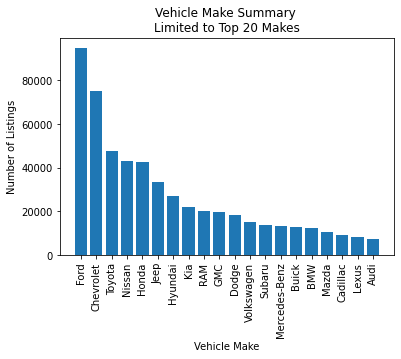

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn

make_count_df = sampled_df.groupBy('make_name').count().orderBy(fn.desc('count')).limit(20).toPandas()

plt.bar(make_count_df['make_name'],make_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Make')
plt.ylabel('Number of Listings')
plt.title('Vehicle Make Summary \nLimited to Top 20 Makes')
plt.show()

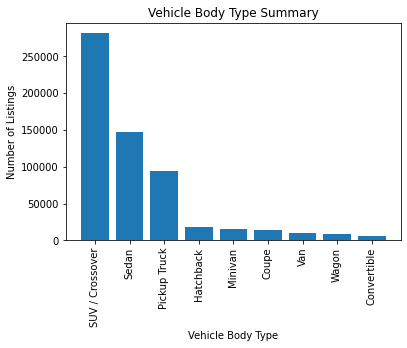

In [ ]:
body_count_df = sampled_df.groupBy('body_type').count().orderBy(fn.desc('count')).dropna().toPandas()

plt.bar(body_count_df['body_type'],body_count_df['count'])
plt.xticks(rotation='vertical')
plt.xlabel('Vehicle Body Type')
plt.ylabel('Number of Listings')
plt.title('Vehicle Body Type Summary')
plt.show()

In [13]:
sampled_df.filter('price >= 1000000').select('price','year','make_name','model_name').show()

+---------+----+-------------+--------------+
|    price|year|    make_name|    model_name|
+---------+----+-------------+--------------+
|1095000.0|2017|      Ferrari|F12 Berlinetta|
|1425000.0|1988|      Porsche|           959|
|1114461.0|2021|Mercedes-Benz|       E-Class|
|1750000.0|1996|          BMW|      7 Series|
|2000000.0|2010|   Koenigsegg|  CCXR Trevita|
|1199500.0|2015|    Chevrolet|          Volt|
|1599500.0|2017|        Dodge| Grand Caravan|
|1100000.0|2012|        Lexus|           LFA|
|1995900.0|1935|Mercedes-Benz|     500-Class|
+---------+----+-------------+--------------+

